# Instructions :
Travail en groupe, à  placer dans le premier dépot Git de notre année Universitaire, dans le dossier <code>Computer Vision</code>.


# Membres du Groupe :

1. ANDRIAMAHENINA Aina Loïc N°01
2. RANDRIAMANALINA Lalaina Jimmy N°05
3. ANDRIAKOTO Rah-Maesch N°06
4. DANIE Anand N°11
5. RANDRIANANTENAINA Jean Carlos N°17
6.
7.


# Autoencodeurs pour Images de Cercles

Dans ce notebook, nous allons générer un dataset synthétique où chaque image est une image en niveaux de gris de taille 64x64 contenant un cercle blanc (de centre et rayon aléatoires) sur fond noir. Le but est d'entraîner des autoencodeurs qui réduisent ces images dans un espace latent de dimension 3, puis les reconstruisent.

Nous étudierons deux configurations :
- Un autoencodeur entièrement connecté
- Un autoencodeur convolutionnel

Vous pourrez comparer leurs performances et discuter des compromis liés à la conception de l'espace latent.

## Étape 1 : Génération du Dataset

Nous allons générer un dataset d'images où chaque image comporte un cercle blanc de centre et de rayon aléatoires. Pour cela, nous utiliserons la bibliothèque OpenCV pour dessiner le cercle sur une image noire.

### Explication Pratique
La génération d'un dataset synthétique permet de contrôler précisément les paramètres (ici, le centre et le rayon du cercle) et de disposer d'une base simple pour expérimenter la réduction dimensionnelle via l'espace latent.

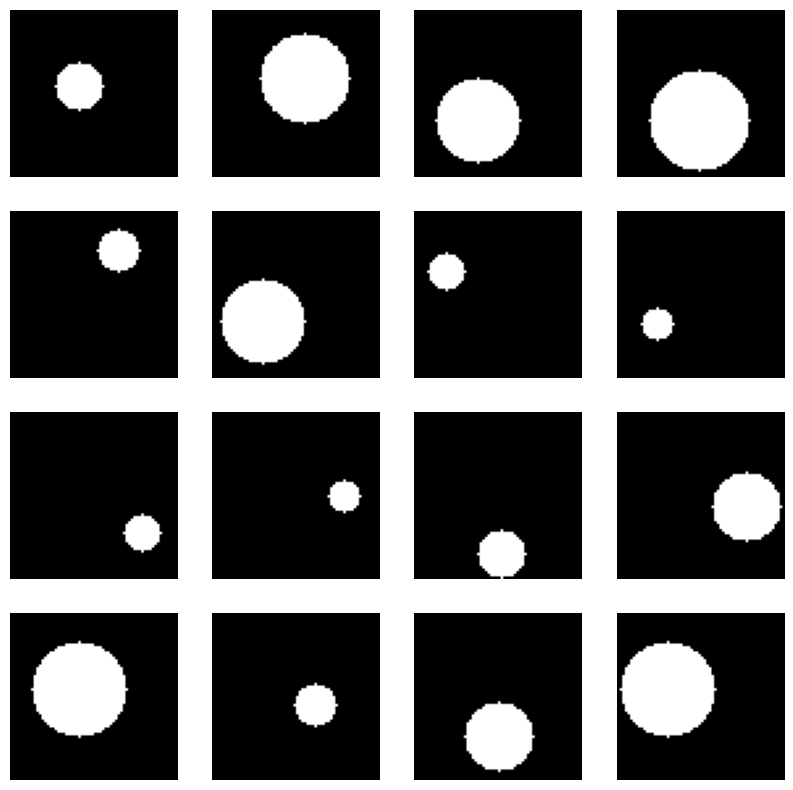

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def generate_circle_image(image_size=64, min_radius=5, max_radius=20):
    """Génère une image en niveaux de gris de taille image_size x image_size contenant un cercle blanc."""
    # Créer une image noire
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    # Choisir un rayon aléatoire
    radius = np.random.randint(min_radius, max_radius)

    # Choisir un centre aléatoire de sorte que le cercle soit entièrement contenu dans l'image
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)

    # Dessiner le cercle (couleur blanche: 255, épaisseur=-1 pour un remplissage complet)
    cv2.circle(image, (x, y), radius, 255, -1)

    # Normaliser l'image entre 0 et 1
    image = image.astype('float32') / 255.0

    return image

def generate_dataset(n_samples=10000, image_size=64):
    data = []
    for _ in range(n_samples):
        img = generate_circle_image(image_size=image_size)
        data.append(img)
    data = np.array(data)
    # Ajouter une dimension pour le canal (images en niveaux de gris)
    data = np.expand_dims(data, axis=-1)
    return data

# Générer le dataset
data = generate_dataset(n_samples=10000, image_size=64)

# Afficher quelques exemples
plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(data[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()


In [15]:
def add_gaussian_noise(image, mean=0, std=0.15):
    """Ajoute un bruit gaussien visible à une image normalisée."""
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = np.clip(image + noise, 0, 1)
    return noisy_image



## Étape 2 : Préparation des Données

Nous allons diviser le dataset en ensembles d'entraînement et de test. Ici, nous utilisons 80 % des données pour l'entraînement et 20 % pour le test.

In [2]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print('Entraînement:', train_data.shape)
print('Test:', test_data.shape)


Entraînement: (8000, 64, 64, 1)
Test: (2000, 64, 64, 1)


## Étape 3 : Autoencodeur Entièrement Connecté (Dense Layers)

Dans cette partie, nous construisons un autoencodeur entièrement connecté. Le modèle comporte :

- **Encodeur :** Un aplatissement de l'image suivi d'une couche Dense de 128 neurones (activation ReLU) puis une couche Dense de 3 neurones qui représente l'espace latent.
- **Décodeur :** Une couche Dense de 128 neurones (activation ReLU), suivie d'une couche Dense de 4096 neurones (pour reconstruire une image 64x64) avec activation sigmoïde, puis un reshape en (64,64,1).

### Explication Pratique
Cet autoencodeur simple permet de voir comment les informations (ici, la position et la taille du cercle) sont comprimées dans un espace de très faible dimension.

In [3]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(64, 64, 1))
x = layers.Flatten()(input_img)
x = layers.Dense(128, activation='relu')(x)
latent = layers.Dense(3, name='latent_space')(x)  # Espace latent de dimension 3

x = layers.Dense(128, activation='relu')(latent)
x = layers.Dense(64*64, activation='sigmoid')(x)
decoded = layers.Reshape((64, 64, 1))(x)

autoencoder_fc = models.Model(input_img, decoded)

autoencoder_fc.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_fc.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │             387 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │         528,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,053,699 (4.02 MB)

 Trainable params: 1,053,699 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Entièrement Connecté FCN (Dense layers)

Nous allons entraîner cet autoencodeur sur l'ensemble d'entraînement.

In [4]:
history_fc = autoencoder_fc.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.4555 - val_loss: 0.1425
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1299 - val_loss: 0.1041
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0977 - val_loss: 0.0866
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0825 - val_loss: 0.0787
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0778 - val_loss: 0.0751
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0739 - val_loss: 0.0723
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0719 - val_loss: 0.0709
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0690 - val_loss: 0.0693
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0679 - val_loss: 0.0678
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0661 - val_loss: 0.0661
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0639 - val_loss: 0.0654
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0642 - val_l

### Visualisation des Reconstructions (FC)

Affichons quelques reconstructions pour évaluer qualitativement les performances de l'autoencodeur entièrement connecté.

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


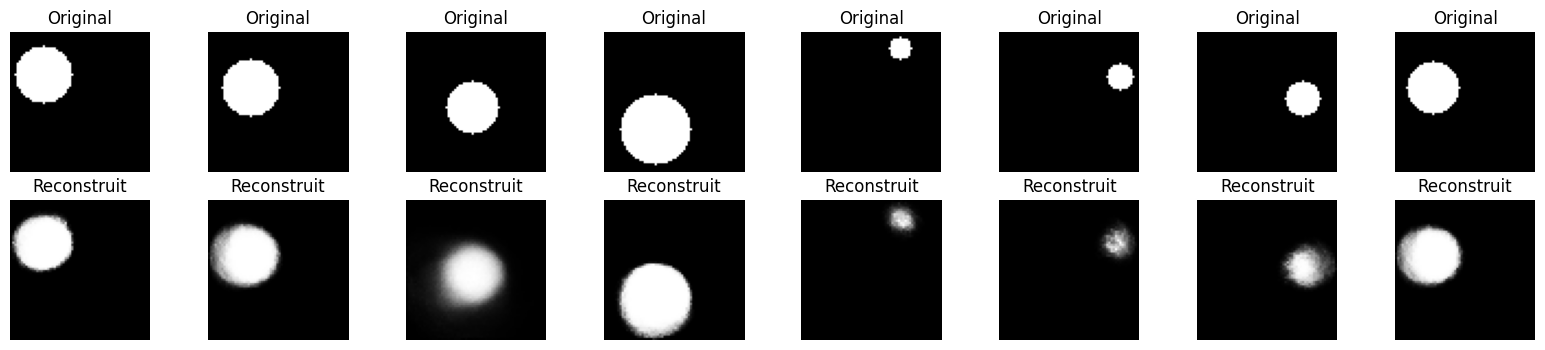

In [5]:
decoded_imgs_fc = autoencoder_fc.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Étape 4 : Autoencodeur Convolutionnel

Nous allons maintenant construire un autoencodeur convolutionnel. Cette architecture est généralement mieux adaptée pour traiter des images car elle exploite la structure spatiale.

### Architecture
- **Encodeur :**
  - Conv2D(32, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Conv2D(64, 3, activation='relu', padding='same')
  - MaxPooling2D((2,2), padding='same')
  - Flatten puis Dense(3) pour obtenir le latent space
- **Décodeur :**
  - Dense(16*16*64, activation='relu') puis Reshape en (16,16,64)
  - Conv2DTranspose(64, 3, strides=2, activation='relu', padding='same')
  - Conv2DTranspose(32, 3, strides=2, activation='relu', padding='same')
  - Conv2D(1, 3, activation='sigmoid', padding='same') pour reconstruire l'image

### Explication Pratique
Les autoencodeurs convolutionnels capturent mieux la structure locale des images, ce qui peut améliorer la qualité des reconstructions par rapport à une architecture entièrement connectée.

In [6]:
input_img = layers.Input(shape=(64, 64, 1))

# Encodeur
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Flatten()(x)
latent = layers.Dense(3, name='latent_space')(x)

# Décodeur
x = layers.Dense(16*16*64, activation='relu')(latent)
x = layers.Reshape((16,16,64))(x)
x = layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder_conv = models.Model(input_img, decoded)

autoencoder_conv.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder_conv.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Dense)                 │ (None, 3)                   │          49,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16384)               │          65,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 189,188 (739.02 KB)

 Trainable params: 189,188 (739.02 KB)

 Non-trainable params: 0 (0.00 B)

### Entraînement de l'Autoencodeur Convolutionnel

Entraînons cet autoencodeur sur le même ensemble d'entraînement.

In [7]:
history_conv = autoencoder_conv.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 115ms/step - loss: 0.5397 - val_loss: 0.3090
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.3043 - val_loss: 0.2073
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1808 - val_loss: 0.1105
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.1019 - val_loss: 0.0787
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0723 - val_loss: 0.0539
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0521 - val_loss: 0.0386
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0373 - val_loss: 0.0366
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0321 - val_loss: 0.0334
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0296 - val_loss: 0.0248
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0245 - val_loss: 0.0250
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0240 - val_loss: 0.0203
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0

### Visualisation des Reconstructions (Convolutionnel)

Affichons quelques reconstructions pour comparer qualitativement les deux architectures.

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


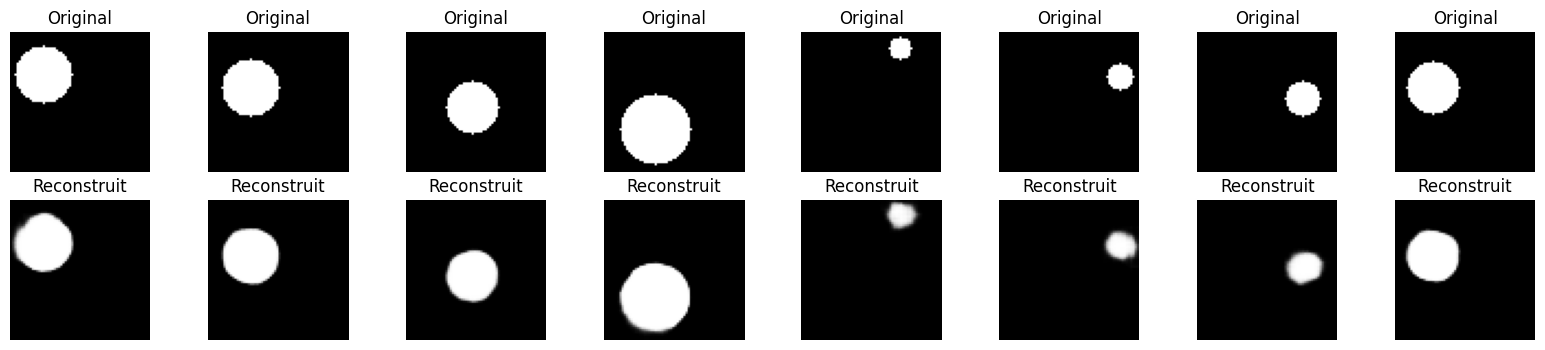

In [8]:
decoded_imgs_conv = autoencoder_conv.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()


## Expérimentations

1. Tester les deux modèles sur des images d'entrées imparfaites (avec les imperfections de votre choix : parties cachées, bruits, ...). Interpréter les résultats.
2. Améliorer un des modèles ci-dessus de votre choix et montrer le résultat (sans modifier la taille de l'espace latent).
3. Selon les expériences menées dans ce notebook, votre avis et vos conaissances, est-il nécessaire d'augmenter la taille de l'espace latent pour avoir un réseau à faire ce travail. **Argumenter** votre réponse.

# Réponses test

1.1 Expérimentation

Afin d’évaluer la robustesse des autoencodeurs face à des entrées altérées, nous avons appliqué des imperfections aux images originales :

- Bruit gaussien : Ajout de bruit aléatoire pour simuler des données bruitées.



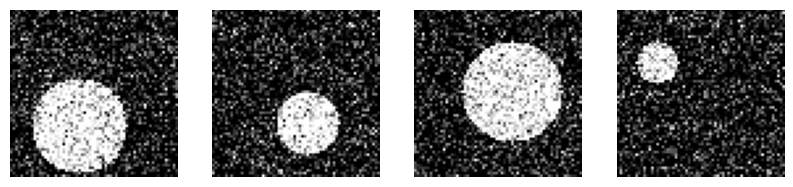

In [27]:
def mask_random_patch(image, mask_size=(10, 10)):
    """Ajoute un masque noir aléatoire sur une image."""
    img_h, img_w = image.shape[:2]
    x = np.random.randint(0, img_w - mask_size[1])
    y = np.random.randint(0, img_h - mask_size[0])

    masked_image = image.copy()
    masked_image[y:y + mask_size[0], x:x + mask_size[1]] = 0
    return masked_image

def generate_circle_image(image_size=64, min_radius=5, max_radius=20):
    """Génère une image en niveaux de gris de taille image_size x image_size contenant un cercle blanc."""
    # Créer une image noire
    image = np.zeros((image_size, image_size), dtype=np.uint8)

    # Choisir un rayon aléatoire
    radius = np.random.randint(min_radius, max_radius)

    # Choisir un centre aléatoire de sorte que le cercle soit entièrement contenu dans l'image
    x = np.random.randint(radius, image_size - radius)
    y = np.random.randint(radius, image_size - radius)

    # Dessiner le cercle (couleur blanche: 255, épaisseur=-1 pour un remplissage complet)
    cv2.circle(image, (x, y), radius, 255, -1)

    # Normaliser l'image entre 0 et 1
    image = image.astype('float32') / 255.0

    return image

def generate_dataset(n_samples=4, image_size=64):
    data = []
    for _ in range(n_samples):
        img = generate_circle_image(image_size=image_size)
        modif_img = add_gaussian_noise(img, std=0.35)
        data.append(modif_img)
    data = np.array(data)
    # Ajouter une dimension pour le canal (images en niveaux de gris)
    data = np.expand_dims(data, axis=-1)
    return data

# Générer le dataset
modified_img = generate_dataset(n_samples=4, image_size=64)

# Afficher quelques exemples
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(4,4,i+1)
    plt.imshow(modified_img[i].squeeze(), cmap='gray')
    plt.axis('off')
plt.show()

Nous avons ensuite fait passer ces images altérées dans les deux autoencodeurs et comparé les reconstructions obtenues.

Premier Modèle

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


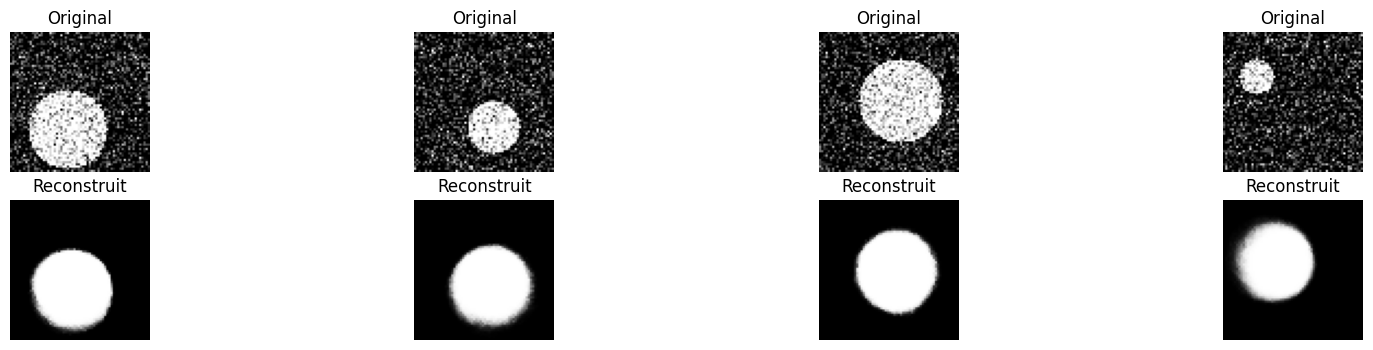

In [28]:
decoded_imgs_fc = autoencoder_fc.predict(modified_img)

n = 4
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(modified_img[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_fc[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()

### Résultats


Test sur le 2ème modèle

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


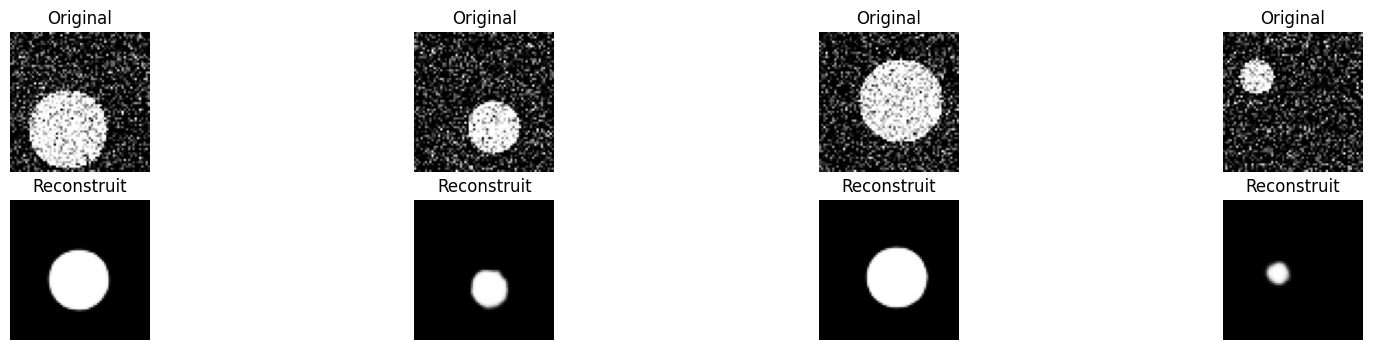

In [29]:
decoded_imgs_conv = autoencoder_conv.predict(modified_img)

n = 4
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(modified_img[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()

### Résultats et Interprétation

### Autoencodeur entièrement connecté (fully connected)
- Bruit : Sensible aux perturbations globales, la reconstruction devient floue et perd en netteté.


### Autoencodeur convolutionnel
- Bruit : Mieux toléré, la reconstruction reste globalement fidèle avec une légère perte de qualité.




2- Amélioration du modèle Autoencodeur Convolutionnel

In [33]:
from tensorflow.keras import layers, models

input_img = layers.Input(shape=(64, 64, 1))

# Encodeur amélioré
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = layers.BatchNormalization()(x)  # Normalisation pour stabiliser l'apprentissage
x = layers.MaxPooling2D((2,2), padding='same')(x)

x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)
x = layers.Dropout(0.2)(x)  # Régularisation pour éviter l'overfitting

x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)

# Bottleneck (espace latent sans perte de structure spatiale)
latent = layers.Conv2D(3, (3,3), activation='relu', padding='same', name='latent_space')(x)

# Décodeur amélioré
x = layers.UpSampling2D((2,2))(latent)
x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)

x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)

x = layers.UpSampling2D((2,2))(x)
x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(x)

decoded = layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

# Compilation avec MSE au lieu de binary crossentropy
autoencoder_conv = models.Model(input_img, decoded)
autoencoder_conv.compile(optimizer='adam', loss='mse')

autoencoder_conv.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ latent_space (Conv2D)                │ (None, 8, 8, 3)             │           3,459 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 128)         │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 64, 64, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 192,644 (752.52 KB)

 Trainable params: 192,452 (751.77 KB)

 Non-trainable params: 192 (768.00 B)

In [34]:
history_conv = autoencoder_conv.fit(train_data, train_data,
                                  epochs=20,
                                  batch_size=128,
                                  shuffle=True,
                                  validation_data=(test_data, test_data))

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 205ms/step - loss: 0.0835 - val_loss: 0.0185
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.0083 - val_loss: 0.0146
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0050 - val_loss: 0.0123
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0041 - val_loss: 0.0113
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0035 - val_loss: 0.0116
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0034 - val_loss: 0.0127
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0029 - val_loss: 0.0100
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0030 - val_loss: 0.0098
Epoch 9/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0.0026 - val_loss: 0.0080
Epoch 10/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - loss: 0

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step


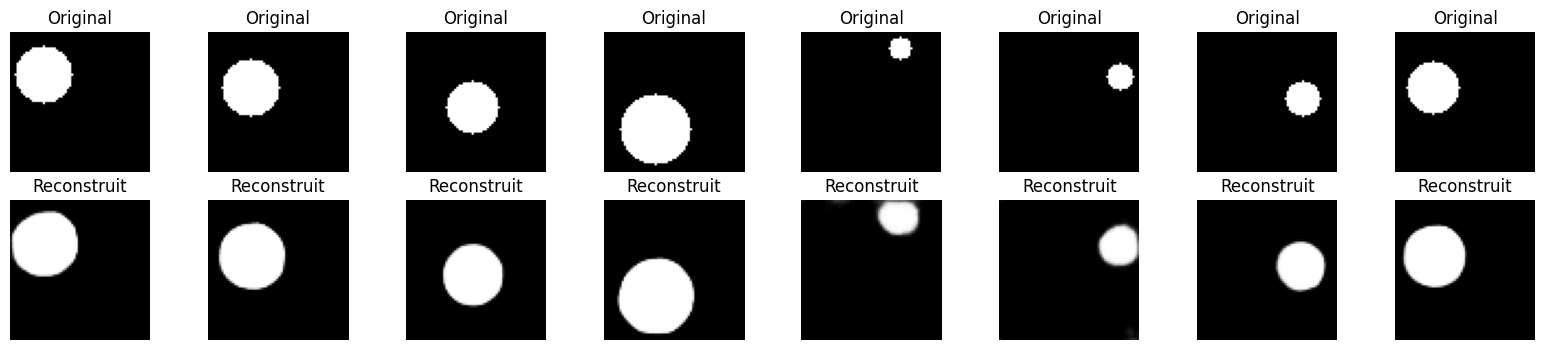

In [32]:
decoded_imgs_conv = autoencoder_conv.predict(test_data)

n = 8
plt.figure(figsize=(20, 4))
for i in range(n):
    # Afficher l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Afficher l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_conv[i].squeeze(), cmap='gray')
    plt.title('Reconstruit')
    plt.axis('off')
plt.show()

### Les Améliorations

1. Conserver la structure spatiale dans l’espace latent
Problème initial : Flatten() suivie d'une couche Dense(3), qui supprime la structure spatiale.

- Solution : Remplacé par une couche Conv2D(3, (3,3), activation='relu', padding='same') pour mieux préserver les relations spatiales dans l’espace latent.



2. Ajout d’une couche convolutive supplémentaire dans l’encodeur
Problème initial : Seulement 2 couches convolutives, limitant la capacité d’extraction des caractéristiques.

- Solution : Ajout d’une troisième couche convolutive (128 filtres) avant d’atteindre le bottleneck.

3. Utilisation de Batch Normalization
Problème initial : L'apprentissage peut être instable à cause des variations internes des activations.

- Solution : Ajout de BatchNormalization() après chaque convolution pour stabiliser et accélérer l'entraînement.

4. Régularisation avec Dropout
Problème initial : Risque d’overfitting si le modèle apprend trop les détails du jeu de données.

- Solution : Ajout de Dropout(0.2) après la deuxième couche MaxPooling2D.

5. Remplacement de Conv2DTranspose par UpSampling2D
Problème initial : Conv2DTranspose peut causer des artefacts de dépliage.

- Solution : Utilisation de UpSampling2D() suivi de Conv2D() pour une reconstruction plus fluide.

 6. Changement de la fonction de perte
Problème initial : binary_crossentropy est sous-optimal pour des images bruitées continues.

- Solution : Remplacement par Mean Squared Error (MSE) pour une reconstruction plus fidèle.

### 3- Augmentation de la taille de l'espace latent

Cela dépend du type de données, de la complexité des images et du niveau de compression souhaité.

### 3-1 Augmentation nécessaire

1- Perte excessive d’informations

- Si l'espace latent est trop petit (ex. 3 dimensions dans ton autoencodeur), il peut trop compresser l'information, entraînant une reconstruction floue ou dégradée.

2- Images complexes avec des textures fines

- Si les images contiennent des textures détaillées, des variations d’éclairage ou des structures complexes, un espace latent plus grand permet de mieux les préserver.

3- Reconnaissance de motifs complexes

- Un espace latent plus large aide le réseau à mieux distinguer les motifs importants, surtout si l'objectif est d’extraire des caractéristiques significatives pour une tâche comme le dénombrement d’objets, la classification, ou le style transfert.

### 3-2 Augmentation non nécessaire

1- Risque de surapprentissage (overfitting)

- Un espace latent trop grand peut mémoriser les images au lieu d'apprendre une représentation généralisée. Cela réduit la capacité du modèle à fonctionner sur des images qu’il n’a jamais vues.

2- Augmentation du temps de calcul

- Un espace latent plus grand signifie plus de paramètres à entraîner, donc un temps d’apprentissage plus long et un risque accru de surentraînement.

3- Simplicité des images

- Si les images sont simples (ex. chiffres manuscrits comme MNIST, objets basiques), un espace latent plus petit est suffisant.